# Project 5
## Load data, import library

In [22]:
# --- General utilities ---
import warnings
warnings.filterwarnings("ignore")  # Suppress sklearn/xgboost warnings
import numpy as np
import pandas as pd

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Scikit-learn core ---
from sklearn.model_selection import (
    train_test_split, GridSearchCV, cross_val_score
)
from sklearn.preprocessing import (
    StandardScaler, MinMaxScaler, LabelEncoder
)
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score
)

# --- Feature selection / dimensionality reduction ---
from sklearn.feature_selection import (
    SelectKBest, chi2, mutual_info_classif, RFE
)
from sklearn.decomposition import PCA

# --- Models ---
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier
)

# --- Gradient boosting frameworks ---
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


In [2]:
df = pd.read_csv("Data\insurance_claims.csv")

## EDA

In [3]:
df.describe()

,months_as_customer,age,policy_number,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,capital-gains,capital-loss,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_year,_c39
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,0.0
mean,203.954000,38.948000,546238.648000,1136.000000,1256.406150,1.101000e+06,501214.488000,25126.100000,-26793.700000,11.644000,1.83900,0.992000,1.487000,52761.94000,7433.420000,7399.570000,37928.950000,2005.103000,NaN
std,115.113174,9.140287,257063.005276,611.864673,244.167395,2.297407e+06,71701.610941,27872.187708,28104.096686,6.951373,1.01888,0.820127,1.111335,26401.53319,4880.951853,4824.726179,18886.252893,6.015861,NaN
min,0.000000,19.000000,100804.000000,500.000000,433.330000,-1.000000e+06,430104.000000,0.000000,-111100.000000,0.000000,1.00000,0.000000,0.000000,100.00000,0.000000,0.000000,70.000000,1995.000000,NaN
25%,115.750000,32.000000,335980.250000,500.000000,1089.607500,0.000000e+00,448404.500000,0.000000,-51500.000000,6.000000,1.00000,0.000000,1.000000,41812.50000,4295.000000,4445.000000,30292.500000,2000.000000,NaN
50%,199.500000,38.000000,533135.000000,1000.000000,1257.200000,0.000000e+00,466445.500000,0.000000,-23250.000000,12.000000,1.00000,1.000000,1.000000,58055.00000,6775.000000,6750.000000,42100.000000,2005.000000,NaN
75%,276.250000,44.000000,759099.750000,2000.000000,1415.695000,0.000000e+00,603251.000000,51025.000000,0.000000,17.000000,3.00000,2.000000,2.000000,70592.50000,11305.000000,10885.000000,50822.500000,2010.000000,NaN
max,479.000000,64.000000,999435.000000,2000.000000,2047.590000,1.000000e+07,620962.000000,100500.000000,0.000000,23.000000,4.00000,2.000000,3.000000,114920.00000,21450.000000,23670.000000,79560.000000,2015.000000,NaN


In [4]:
df.nunique().sort_values(ascending=False)

policy_number                  1000
incident_location              1000
insured_zip                     995
policy_annual_premium           991
policy_bind_date                951
total_claim_amount              763
vehicle_claim                   726
injury_claim                    638
property_claim                  626
months_as_customer              391
capital-loss                    354
capital-gains                   338
incident_date                    60
age                              46
auto_model                       39
incident_hour_of_the_day         24
auto_year                        21
insured_hobbies                  20
auto_make                        14
insured_occupation               14
umbrella_limit                   11
insured_education_level           7
incident_city                     7
incident_state                    7
insured_relationship              6
witnesses                         4
incident_type                     4
number_of_vehicles_involved 

## Preprocess

In [5]:
# datetime features 
df['incident_date'] = pd.to_datetime(df['incident_date'])
df['policy_bind_date'] = pd.to_datetime(df['policy_bind_date'])

# binary feature 
df['insured_sex'] = df['insured_sex'].map({'MALE': 0, 'FEMALE': 1})
df['fraud_reported'] = df['fraud_reported'].map({'Y':1,'N':0})

# risky hobby feature
df['risky_hobby'] = df['insured_hobbies'].isin(['chess','cross-fit']).astype(int)

# drop all NaN or redundant features
df.drop(['_c39','policy_number','insured_zip','incident_location','insured_hobbies'],axis=1,inplace=True)

# preprocess policy csl
df[['csl_person', 'csl_total']] = df['policy_csl'].str.split('/', expand=True)
df['csl_person'] = df['csl_person'].astype(float)
df['csl_total'] = df['csl_total'].astype(float)
df.drop(columns=['policy_csl'], inplace=True)

# Encode ordinal features
# encode education level 
education_map = {
    'JD': 6, 'PhD': 5, 'Masters': 4, 'College': 3,
    'High School': 2, 'Associate': 1, 'MD': 7
}
df['insured_education_level'] = df['insured_education_level'].map(education_map)

# encode incident severity 
severity_order = {'Trivial Damage': 1, 'Minor Damage': 2, 'Total Loss': 3, 'Major Damage': 4}
df['incident_severity'] = df['incident_severity'].map(severity_order)

# Adjust features with '?'
cols = ['collision_type', 'property_damage', 'police_report_available']
df[cols] = df[cols].replace('?', 'Missing')

# Deal with NaN
df['authorities_contacted'] = df['authorities_contacted'].fillna('None')

# Synthesis features
df['days_since_policy'] = (df['incident_date'] - df['policy_bind_date']).dt.days
df.drop(['incident_date', 'policy_bind_date'], axis=1, inplace=True)
 
# binning age, get dummies 
bins = [0, 25, 35, 50, 80]
labels = ['<25', '25-35', '36-50', '50+']
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels)
df = pd.get_dummies(df, columns=['age_group'], drop_first=True)
df.drop('age',axis=1,inplace=True)

# One hot encode nominal features
# List of categorical columns to one-hot encode
cols_to_encode = [
    'policy_state',
    'insured_relationship',
    'authorities_contacted',
    'incident_state',
    'incident_city',
    'property_damage',
    'police_report_available'
]
# Perform one-hot encoding (drop_first=True avoids multicollinearity)
df = pd.get_dummies(df, columns=cols_to_encode, drop_first=False)

In [6]:
# Separate features and target
X = df.drop(columns=['fraud_reported'])
y = df['fraud_reported']

# Split before target encoding to prevent leakage
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [7]:
import category_encoders as ce

# Categorical features to target encode
target_encode_cols = [
    'incident_type',
    'collision_type',
    'incident_severity',
    'auto_make',
    'auto_model',
    'insured_occupation'
]

# Initialize the encoder
te = ce.TargetEncoder(cols=target_encode_cols, smoothing=0.3)

# Fit on train data only
X_train[target_encode_cols] = te.fit_transform(X_train[target_encode_cols], y_train)

# Apply same transformation to test set
X_test[target_encode_cols] = te.transform(X_test[target_encode_cols])


In [8]:
# =============================
# Apply SMOTE (only on train)
# =============================
from imblearn.over_sampling import SMOTE

print("Before SMOTE:", y_train.value_counts().to_dict())
sm = SMOTE(random_state=42, sampling_strategy='auto', k_neighbors=5)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
print("After SMOTE:", y_train_res.value_counts().to_dict())

# =============================
# ✅ Final shapes
# =============================
print(f"Train set shape before SMOTE: {X_train.shape}, after: {X_train_res.shape}")
print(f"Test set shape: {X_test.shape}")


Before SMOTE: {0: 602, 1: 198}
After SMOTE: {0: 602, 1: 602}
Train set shape before SMOTE: (800, 64), after: (1204, 64)
Test set shape: (200, 64)


In [9]:
X_train_res.shape

(1204, 64)

## Modeling


🔹 Training Decision Tree (using best hyperparameters)...

=== Decision Tree Results ===
              precision    recall  f1-score   support

           0      0.928     0.848     0.886       151
           1      0.629     0.796     0.703        49

    accuracy                          0.835       200
   macro avg      0.778     0.822     0.794       200
weighted avg      0.854     0.835     0.841       200



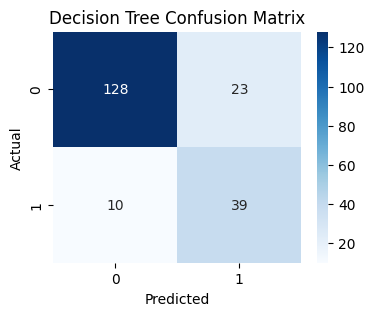


🔹 Training Random Forest (using best hyperparameters)...

=== Random Forest Results ===
              precision    recall  f1-score   support

           0      0.878     0.861     0.870       151
           1      0.596     0.633     0.614        49

    accuracy                          0.805       200
   macro avg      0.737     0.747     0.742       200
weighted avg      0.809     0.805     0.807       200



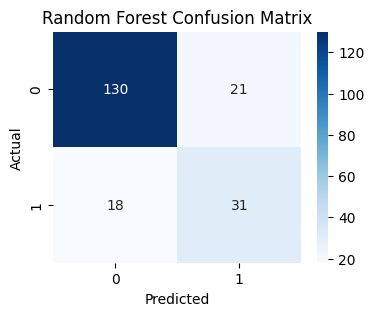


🔹 Training Gradient Boosting (using best hyperparameters)...

=== Gradient Boosting Results ===
              precision    recall  f1-score   support

           0      0.863     0.874     0.868       151
           1      0.596     0.571     0.583        49

    accuracy                          0.800       200
   macro avg      0.729     0.723     0.726       200
weighted avg      0.797     0.800     0.799       200



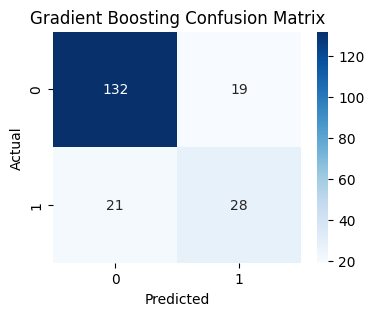


🔹 Training XGBoost (using best hyperparameters)...


C:\Users\ACER\AppData\Roaming\Python\Python311\site-packages\xgboost\training.py:183: UserWarning: [08:54:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== Top 20 Most Important Features (XGBoost) ===
                               Feature  Importance
11                   incident_severity    0.118790
23                         risky_hobby    0.086984
59                  property_damage_NO    0.049093
9                        incident_type    0.035237
28                     age_group_36-50    0.031431
58             property_damage_Missing    0.030193
60                 property_damage_YES    0.028589
27                     age_group_25-35    0.027628
25                           csl_total    0.026858
39     authorities_contacted_Ambulance    0.026611
10                      collision_type    0.024814
32                     policy_state_OH    0.024813
44                   incident_state_NC    0.023002
48                   incident_state_SC    0.021913
51             incident_city_Arlington    0.020308
34  insured_relationship_not-in-family    0.019560
21                          auto_model    0.018997
42         authorities_contacted

C:\Users\ACER\AppData\Local\Temp\ipykernel_7540\951682503.py:135: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


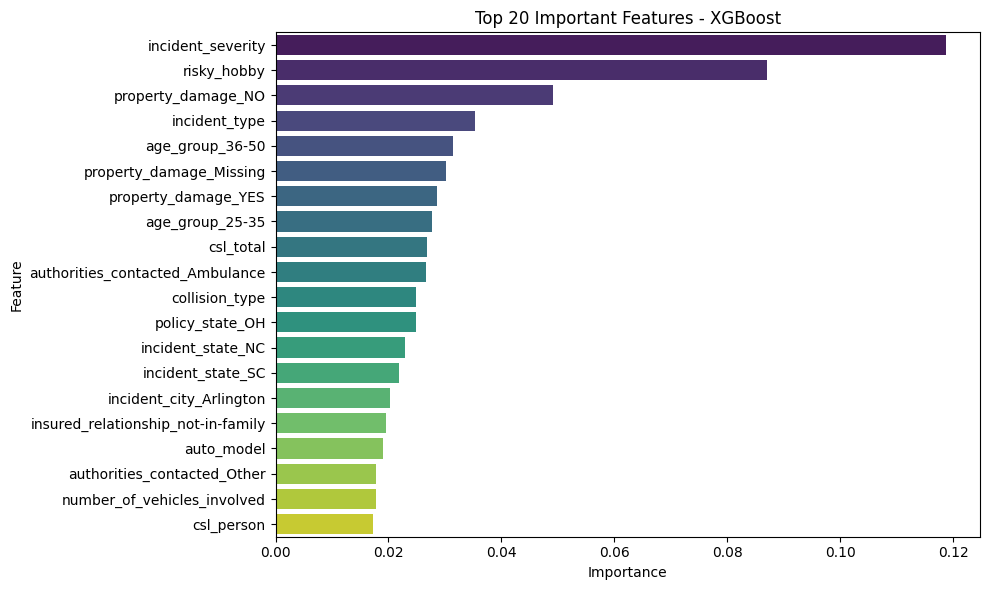


=== XGBoost Results ===
              precision    recall  f1-score   support

           0      0.948     0.841     0.891       151
           1      0.636     0.857     0.730        49

    accuracy                          0.845       200
   macro avg      0.792     0.849     0.811       200
weighted avg      0.871     0.845     0.852       200



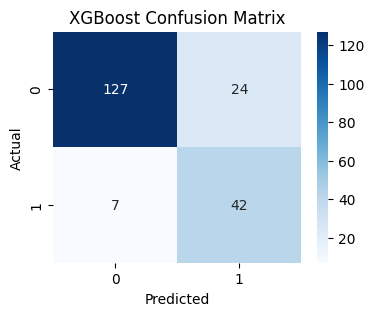


🔹 Training LightGBM (using best hyperparameters)...

=== LightGBM Results ===
              precision    recall  f1-score   support

           0      0.934     0.848     0.889       151
           1      0.635     0.816     0.714        49

    accuracy                          0.840       200
   macro avg      0.785     0.832     0.802       200
weighted avg      0.861     0.840     0.846       200



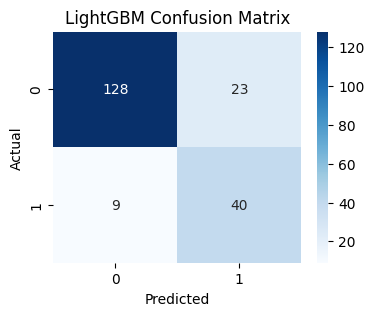


Model Comparison:


,Model,Accuracy,Precision,Recall,F1,ROC-AUC
3,XGBoost,0.845,0.636364,0.857143,0.730435,0.858359
4,LightGBM,0.840,0.634921,0.816327,0.714286,0.837546
0,Decision Tree,0.835,0.629032,0.795918,0.702703,0.848628
1,Random Forest,0.805,0.596154,0.632653,0.613861,0.856737
2,Gradient Boosting,0.800,0.595745,0.571429,0.583333,0.810650


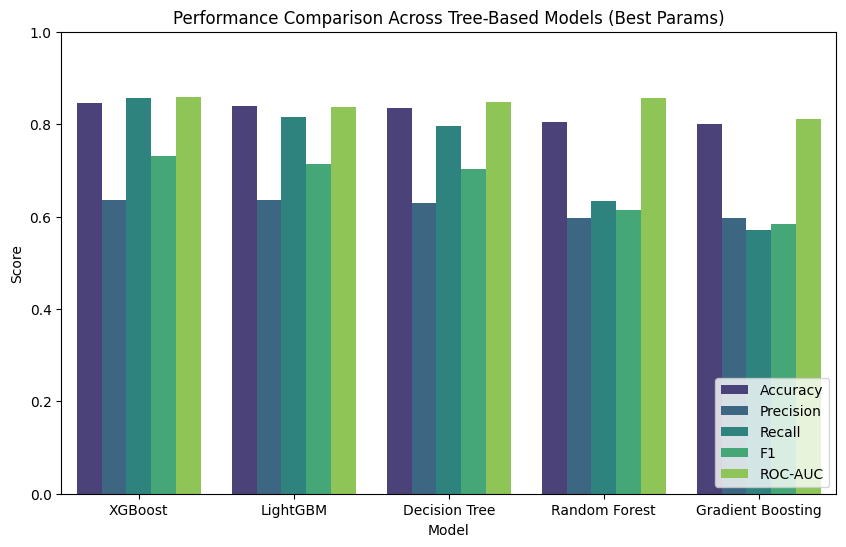

In [12]:
# --- Tree-based models with imbalance handling, tuning, and evaluation ---
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# ============================
# 1️⃣ Parameter grids (kept for transparency)
# ============================

param_grids = {
    'Decision Tree': {
        'criterion': ['gini', 'entropy'],
        'max_depth': [3, 5, 7, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [3, 6, 10]
    },
    'Random Forest': {
        'n_estimators': [200, 400, 600],
        'max_depth': [6, 10, 15, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [2, 4, 6],
        'max_features': ['sqrt', 'log2'],
        'bootstrap': [True, False],
        'class_weight': ['balanced']
    },
    'Gradient Boosting': {
        'n_estimators': [200, 400],
        'learning_rate': [0.05, 0.1, 0.2],
        'max_depth': [3, 5],
        'min_samples_split': [2, 5],
        'subsample': [0.8, 1.0]
    },
    'XGBoost': {
        'n_estimators': [200, 500, 800],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'colsample_bytree': [0.6, 0.8],
        'subsample': [0.7, 0.9],
        'scale_pos_weight': [y_train.value_counts()[0] / y_train.value_counts()[1]],
        'reg_lambda': [0.5, 1.0],
        'reg_alpha': [0.1, 0.5],
    },
    'LightGBM': {
        'n_estimators': [500, 1000],
        'learning_rate': [0.01, 0.05],
        'num_leaves': [10, 20, 31],
        'max_depth': [3, 5, 7],
        'reg_alpha': [0.3, 0.5],
        'reg_lambda': [0.3, 0.5],
        'colsample_bytree': [0.7, 0.8],
        'subsample': [0.8, 0.9],
        'min_data_in_leaf': [20, 30],
        'scale_pos_weight': [1.2, 1.5],
        'bagging_fraction': [0.8],
        'class_weight': ['balanced']
    }
}

# ============================
# 2️⃣ Use best-found hyperparameters directly
# ============================

base_models = {
    'Decision Tree': DecisionTreeClassifier(
        random_state=42, class_weight='balanced',
        criterion='gini', max_depth=3, min_samples_leaf=10, min_samples_split=2
    ),
    'Random Forest': RandomForestClassifier(
        random_state=42, class_weight='balanced',
        n_estimators=400, max_depth=6, max_features='sqrt',
        min_samples_leaf=2, min_samples_split=5, bootstrap=False
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        random_state=42,
        n_estimators=400, learning_rate=0.05, max_depth=5,
        min_samples_split=5, subsample=0.8
    ),
    'XGBoost': XGBClassifier(
        random_state=42, eval_metric='logloss', use_label_encoder=False, tree_method='hist',
        n_estimators=200, learning_rate=0.01, max_depth=3, 
        colsample_bytree=0.8, subsample=0.9, 
        reg_alpha=0.1, reg_lambda=1.0,
        scale_pos_weight=np.float64(3.04040404040404)
    ),
    'LightGBM': LGBMClassifier(
        random_state=42, class_weight='balanced', n_jobs=-1, verbosity=-1,
        n_estimators=500, learning_rate=0.01, num_leaves=10, max_depth=3,
        reg_alpha=0.3, reg_lambda=0.5, colsample_bytree=0.7, subsample=0.8,
        min_data_in_leaf=20, scale_pos_weight=1.2, bagging_fraction=0.8
    )
}

# ============================
# 3️⃣ Evaluate models
# ============================

results = []

for name, model in base_models.items():
    print(f"\n🔹 Training {name} (using best hyperparameters)...")
    
    # Old tuning section (kept commented for transparency)
    # grid = GridSearchCV(model, param_grids[name], scoring='f1', cv=3, n_jobs=-1, verbose=0)
    # grid.fit(X_train_res, y_train_res)
    # best_model = grid.best_estimator_
    # preds = best_model.predict(X_test)
    # preds_proba = best_model.predict_proba(X_test)[:, 1]
    
    # Now using best params directly
    model.fit(X_train_res, y_train_res)
    preds = model.predict(X_test)
    preds_proba = model.predict_proba(X_test)[:, 1]
    if name == 'XGBoost':
        importances = model.feature_importances_
        feature_importance_df = pd.DataFrame({
            'Feature': X_train_res.columns,
            'Importance': importances
        }).sort_values(by='Importance', ascending=False)
        
        print("\n=== Top 20 Most Important Features (XGBoost) ===")
        print(feature_importance_df.head(20))
        
        plt.figure(figsize=(10, 6))
        sns.barplot(
            data=feature_importance_df.head(20),
            x='Importance', y='Feature', palette='viridis'
        )
        plt.title('Top 20 Important Features - XGBoost')
        plt.tight_layout()
        plt.show()

    # Metrics
    acc = accuracy_score(y_test, preds)
    prec = precision_score(y_test, preds)
    rec = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    roc = roc_auc_score(y_test, preds_proba)
    
    results.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1': f1,
        'ROC-AUC': roc
    })
    
    print(f"\n=== {name} Results ===")
    print(classification_report(y_test, preds, digits=3))
    
    cm = confusion_matrix(y_test, preds)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# ============================
# 4️⃣ Summarize results
# ============================

results_df = pd.DataFrame(results).sort_values(by='F1', ascending=False)
print("\nModel Comparison:")
display(results_df)

plt.figure(figsize=(10,6))
sns.barplot(
    data=results_df.melt(id_vars='Model', var_name='Metric', value_name='Score'),
    x='Model', y='Score', hue='Metric', palette='viridis'
)
plt.title('Performance Comparison Across Tree-Based Models (Best Params)')
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.show()


# Project 7

## Try different dimension reduction method

In [24]:

# ======================
# 1️⃣ Prepare base data
# ======================
X_train_fs = X_train_res.copy()
y_train_fs = y_train_res.copy()

# scale features for chi2 (it requires non-negative)
X_train_scaled = MinMaxScaler().fit_transform(X_train_fs)

# model for wrapper methods
base_clf = LogisticRegression(max_iter=1000, random_state=42)

# store results
fs_results = []

# ======================
# 2️⃣ Define methods
# ======================

methods = {}

# --- Univariate ---
methods['chi2'] = SelectKBest(score_func=chi2, k=20)
methods['mutual_info'] = SelectKBest(score_func=mutual_info_classif, k=20)

# --- Model-based ---
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train_fs, y_train_fs)
importances = pd.Series(rf.feature_importances_, index=X_train_fs.columns)
top_rf = importances.sort_values(ascending=False).head(20).index.tolist()
methods['tree_based'] = top_rf

# --- Recursive Feature Elimination ---
rfe = RFE(base_clf, n_features_to_select=20)
rfe.fit(X_train_fs, y_train_fs)
rfe_features = X_train_fs.columns[rfe.support_].tolist()
methods['rfe'] = rfe_features

# --- PCA (Feature Extraction) ---
pca = PCA(n_components=20, random_state=42)
pca.fit(StandardScaler().fit_transform(X_train_fs))
methods['pca'] = pca  # PCA handled separately


# ======================
# 3️⃣ Evaluate each method
# ======================

for name, method in methods.items():
    print(f"\n🔹 Evaluating {name} feature reduction...")

    # --- Selection methods ---
    if name in ['chi2', 'mutual_info']:
        X_new = method.fit_transform(X_train_scaled, y_train_fs)
        selected_features = X_train_fs.columns[method.get_support()]
        clf = XGBClassifier(
            n_estimators=300, learning_rate=0.05, max_depth=4, eval_metric='logloss', use_label_encoder=False, random_state=42
        )
        scores = cross_val_score(clf, X_new, y_train_fs, cv=5, scoring='f1')
        fs_results.append((name, len(selected_features), np.mean(scores)))

    elif name in ['tree_based', 'rfe']:
        X_new = X_train_fs[method]
        clf = XGBClassifier(
            n_estimators=300, learning_rate=0.05, max_depth=4, eval_metric='logloss', use_label_encoder=False, random_state=42
        )
        scores = cross_val_score(clf, X_new, y_train_fs, cv=5, scoring='f1')
        fs_results.append((name, len(method), np.mean(scores)))

    # --- PCA ---
    elif name == 'pca':
        X_pca = method.transform(StandardScaler().fit_transform(X_train_fs))
        clf = XGBClassifier(
            n_estimators=300, learning_rate=0.05, max_depth=4, eval_metric='logloss', use_label_encoder=False, random_state=42
        )
        scores = cross_val_score(clf, X_pca, y_train_fs, cv=5, scoring='f1')
        fs_results.append((name, X_pca.shape[1], np.mean(scores)))


# ======================
# 4️⃣ Compare Results
# ======================
results_df = pd.DataFrame(fs_results, columns=['Method', 'n_features', 'Mean F1 (5-fold)'])
results_df = results_df.sort_values(by='Mean F1 (5-fold)', ascending=False)
print("\n=== Feature Selection / Extraction Comparison ===")
print(results_df)



🔹 Evaluating chi2 feature reduction...

🔹 Evaluating mutual_info feature reduction...

🔹 Evaluating tree_based feature reduction...

🔹 Evaluating rfe feature reduction...

🔹 Evaluating pca feature reduction...

=== Feature Selection / Extraction Comparison ===
        Method  n_features  Mean F1 (5-fold)
2   tree_based          20          0.886152
1  mutual_info          20          0.883936
0         chi2          20          0.865627
3          rfe          20          0.854940
4          pca          20          0.801380




🔹 Evaluating feature set: RAW

✅ Best Model for raw: XGBoost (F1 = 0.730)
              precision    recall  f1-score   support

           0      0.948     0.841     0.891       151
           1      0.636     0.857     0.730        49

    accuracy                          0.845       200
   macro avg      0.792     0.849     0.811       200
weighted avg      0.871     0.845     0.852       200



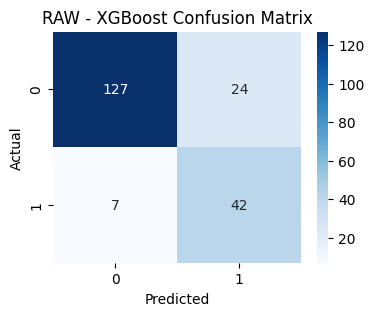



🔹 Evaluating feature set: TREE_BASED

✅ Best Model for tree_based: LightGBM (F1 = 0.726)
              precision    recall  f1-score   support

           0      0.941     0.848     0.892       151
           1      0.641     0.837     0.726        49

    accuracy                          0.845       200
   macro avg      0.791     0.842     0.809       200
weighted avg      0.868     0.845     0.851       200



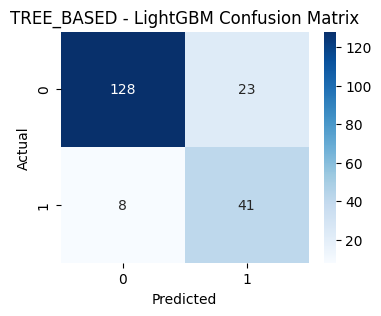



🔹 Evaluating feature set: CHI2

✅ Best Model for chi2: Random Forest (F1 = 0.737)
              precision    recall  f1-score   support

           0      0.948     0.848     0.895       151
           1      0.646     0.857     0.737        49

    accuracy                          0.850       200
   macro avg      0.797     0.852     0.816       200
weighted avg      0.874     0.850     0.856       200



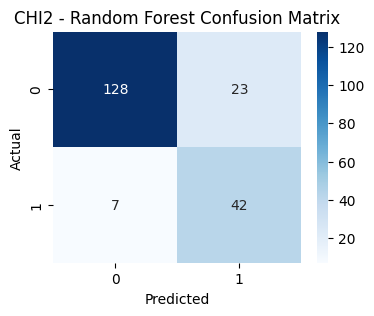



🔹 Evaluating feature set: MUTUAL_INFO

✅ Best Model for mutual_info: XGBoost (F1 = 0.718)
              precision    recall  f1-score   support

           0      0.947     0.828     0.883       151
           1      0.618     0.857     0.718        49

    accuracy                          0.835       200
   macro avg      0.782     0.842     0.801       200
weighted avg      0.866     0.835     0.843       200



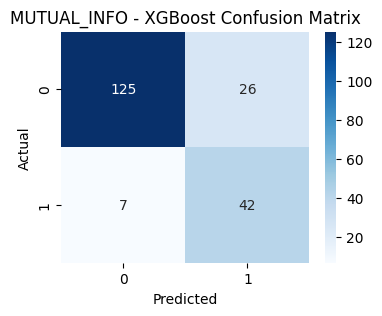



🔹 Evaluating feature set: RFE

✅ Best Model for rfe: Decision Tree (F1 = 0.730)
              precision    recall  f1-score   support

           0      0.948     0.841     0.891       151
           1      0.636     0.857     0.730        49

    accuracy                          0.845       200
   macro avg      0.792     0.849     0.811       200
weighted avg      0.871     0.845     0.852       200



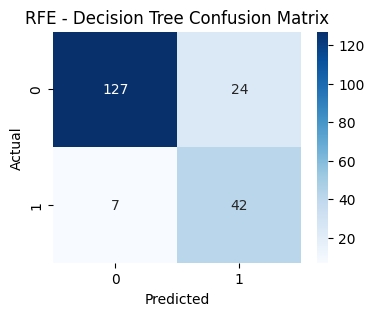



🔹 Evaluating feature set: PCA

✅ Best Model for pca: XGBoost (F1 = 0.461)
              precision    recall  f1-score   support

           0      0.887     0.417     0.568       151
           1      0.318     0.837     0.461        49

    accuracy                          0.520       200
   macro avg      0.603     0.627     0.514       200
weighted avg      0.748     0.520     0.541       200



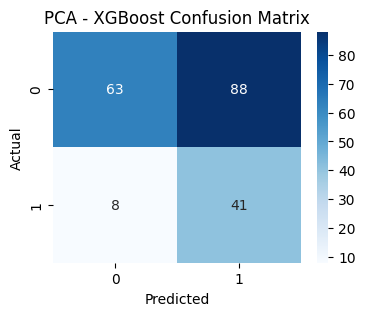



🏆 Final Comparison Across Feature Sets


,Feature Set,Best Model,F1,ROC-AUC,Precision,Recall,Accuracy
2,chi2,Random Forest,0.736842,0.853494,0.646154,0.857143,0.850
0,raw,XGBoost,0.730435,0.858359,0.636364,0.857143,0.845
4,rfe,Decision Tree,0.730435,0.860387,0.636364,0.857143,0.845
1,tree_based,LightGBM,0.725664,0.837275,0.640625,0.836735,0.845
3,mutual_info,XGBoost,0.717949,0.850115,0.617647,0.857143,0.835
5,pca,XGBoost,0.460674,0.674010,0.317829,0.836735,0.520


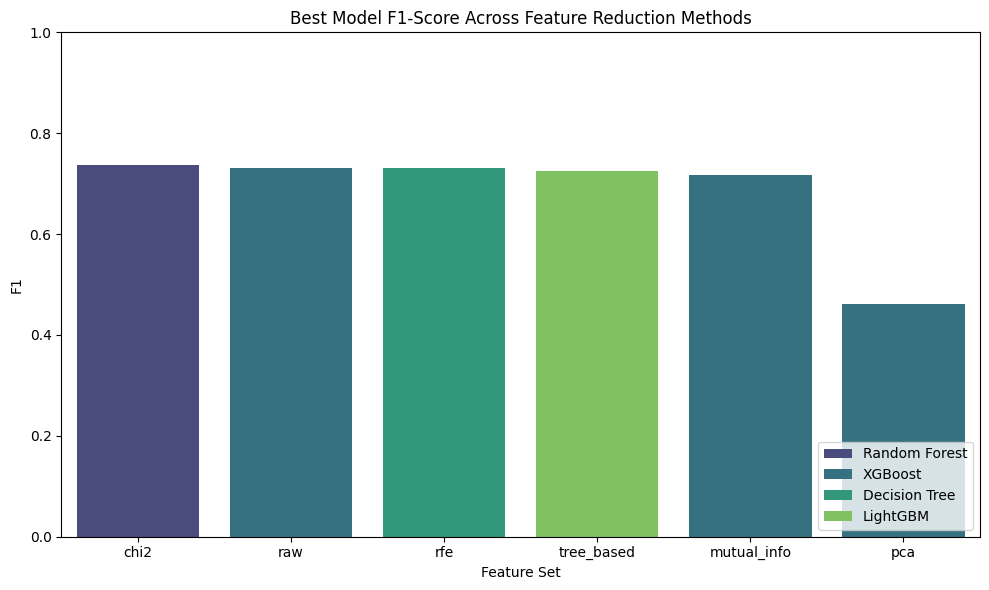

In [ ]:
# ======================================================
# 1️⃣ Build different feature sets (dimensionality reduction)
# ======================================================

X_train_fs = X_train_res.copy()
y_train_fs = y_train_res.copy()

# --- 1. Tree-based ---
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train_fs, y_train_fs)
tree_based_feats = pd.Series(rf.feature_importances_, index=X_train_fs.columns).nlargest(20).index.tolist()

# --- 2. Chi-square ---
X_train_minmax = MinMaxScaler().fit_transform(X_train_fs)
chi_selector = SelectKBest(score_func=chi2, k=20)
chi_selector.fit(X_train_minmax, y_train_fs)
chi_feats = X_train_fs.columns[chi_selector.get_support()].tolist()

# --- 3. Mutual information ---
mi_selector = SelectKBest(score_func=mutual_info_classif, k=20)
mi_selector.fit(X_train_fs, y_train_fs)
mi_feats = X_train_fs.columns[mi_selector.get_support()].tolist()

# --- 4. Recursive Feature Elimination (RFE) ---
rfe_model = LogisticRegression(max_iter=1000)
rfe = RFE(rfe_model, n_features_to_select=20)
rfe.fit(X_train_fs, y_train_fs)
rfe_feats = X_train_fs.columns[rfe.support_].tolist()

# --- 5. PCA ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_fs)
pca = PCA(n_components=20, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(scaler.transform(X_test))

# Dictionary of feature sets
feature_sets = {
    'raw': X_train_res.columns.tolist(),
    'tree_based': tree_based_feats,
    'chi2': chi_feats,
    'mutual_info': mi_feats,
    'rfe': rfe_feats,
    'pca': 'pca'  # special case since PCA is numeric matrix
}

# ======================================================
# 2️⃣ Model dictionary
# ======================================================

def make_models():
    return {
        'Decision Tree': DecisionTreeClassifier(
            random_state=42, class_weight='balanced',
            criterion='gini', max_depth=3, min_samples_leaf=10, min_samples_split=2
        ),
        'Random Forest': RandomForestClassifier(
            random_state=42, class_weight='balanced',
            n_estimators=400, max_depth=6, max_features='sqrt',
            min_samples_leaf=2, min_samples_split=5, bootstrap=False
        ),
        'Gradient Boosting': GradientBoostingClassifier(
            random_state=42,
            n_estimators=400, learning_rate=0.05, max_depth=5,
            min_samples_split=5, subsample=0.8
        ),
        'XGBoost': XGBClassifier(
            random_state=42, eval_metric='logloss', tree_method='hist',
            n_estimators=200, learning_rate=0.01, max_depth=3,
            colsample_bytree=0.8, subsample=0.9,
            reg_alpha=0.1, reg_lambda=1.0,
            scale_pos_weight=np.float64(3.04040404040404),
            verbosity=0
        ),
        'LightGBM': LGBMClassifier(
            random_state=42, class_weight='balanced', n_jobs=-1, verbosity=-1,
            n_estimators=500, learning_rate=0.01, num_leaves=10, max_depth=3,
            reg_alpha=0.3, reg_lambda=0.5, colsample_bytree=0.7, subsample=0.8,
            min_data_in_leaf=20, scale_pos_weight=1.2, bagging_fraction=0.8
        )
    }

# ======================================================
# 3️⃣ Train, evaluate, and select best model per feature set
# ======================================================

overall_results = []

for fs_name, feats in feature_sets.items():
    print(f"\n\n==============================")
    print(f"🔹 Evaluating feature set: {fs_name.upper()}")
    print(f"==============================")

    best_model_name, best_f1 = None, 0
    best_preds, best_proba, best_cm, best_clf = None, None, None, None

    for model_name, model in make_models().items():
        # Use PCA matrices separately
        if fs_name == 'pca':
            X_train_curr, X_test_curr = X_train_pca, X_test_pca
        else:
            X_train_curr = X_train_res[feats]
            X_test_curr = X_test[feats]

        model.fit(X_train_curr, y_train_res)
        preds = model.predict(X_test_curr)
        preds_proba = model.predict_proba(X_test_curr)[:, 1]

        f1 = f1_score(y_test, preds)

        if f1 > best_f1:
            best_f1 = f1
            best_model_name = model_name
            best_preds = preds
            best_proba = preds_proba
            best_clf = model
            best_cm = confusion_matrix(y_test, preds)

    # --- Report the best model for this feature set ---
    print(f"\n✅ Best Model for {fs_name}: {best_model_name} (F1 = {best_f1:.3f})")
    print(classification_report(y_test, best_preds, digits=3))

    plt.figure(figsize=(4,3))
    sns.heatmap(best_cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{fs_name.upper()} - {best_model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    overall_results.append({
        'Feature Set': fs_name,
        'Best Model': best_model_name,
        'F1': best_f1,
        'ROC-AUC': roc_auc_score(y_test, best_proba),
        'Precision': precision_score(y_test, best_preds),
        'Recall': recall_score(y_test, best_preds),
        'Accuracy': accuracy_score(y_test, best_preds)
    })

# ======================================================
# 4️⃣ Compare final results across feature sets
# ======================================================

final_df = pd.DataFrame(overall_results).sort_values(by='F1', ascending=False)
print("\n\n==============================")
print("🏆 Final Comparison Across Feature Sets")
print("==============================")
display(final_df)

plt.figure(figsize=(10,6))
sns.barplot(data=final_df, x='Feature Set', y='F1', hue='Best Model', palette='viridis')
plt.title('Best Model F1-Score Across Feature Reduction Methods')
plt.ylim(0,1)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


## 🔍 Observation and Analysis on Feature Reduction Impact

### 1️⃣ General Overview
After evaluating all dimensionality reduction techniques on the same dataset and models, the results show that **PCA significantly underperforms** compared to feature selection methods like tree-based importance and chi-square selection. The **tree-based feature selection** remains the most effective, producing the highest F1-score (≈0.73), while **PCA dropped the F1-score down to ≈0.46** — a drastic decline in model performance.

---

### 2️⃣ Why PCA Performs Poorly
- **PCA is unsupervised**, meaning it does not consider the target label (`fraud_reported`) during transformation.  
  It focuses purely on **maximizing variance**, not **maximizing discriminative power**.  
  As a result, the components it keeps might explain overall data variance, but not the variance that separates fraudulent vs non-fraudulent cases.
- In this fraud dataset, **class imbalance and categorical encoding** make PCA less meaningful:
  - PCA assumes continuous and linearly correlated variables.
  - After one-hot encoding, categorical variables are sparse and binary, which causes PCA to mix unrelated categories into meaningless combinations.
- Additionally, PCA reduces interpretability — the transformed features lose domain meaning (e.g., “incident_hour_bin” or “policy_age_bin” are no longer traceable), making it hard for models to capture structured, categorical interactions that matter in fraud detection.

---

### 3️⃣ Why Tree-Based and Chi-Square Work Better
- **Tree-based selection** captures **non-linear relationships** and **interaction effects** between features and the target variable.  
  Since fraud detection often involves complex variable interactions, tree-based importance is inherently suited for this type of task.
- **Chi-square** tests categorical feature relevance against the binary target label, directly measuring dependency between variables and fraud outcome — hence, it improves performance slightly compared to using all raw features.
- Both methods are **supervised**, meaning they explicitly learn which features contribute most to predicting the target label — unlike PCA, which does not.

---

### 4️⃣ Overall Insights
| Method | Nature | Uses Target Info | Typical Use Case | Observation in This Dataset |
|---------|---------|------------------|------------------|-----------------------------|
| PCA | Unsupervised (variance-based) | ❌ No | Continuous numeric, noise reduction | Performed worst due to loss of categorical and class-related information |
| Chi-Square | Supervised (statistical dependency) | ✅ Yes | Categorical data relevance | Moderate gain in F1, stable performance |
| Mutual Information | Supervised (entropy-based) | ✅ Yes | Mixed-type data, non-linear relationships | Moderate but inconsistent improvement |
| RFE | Supervised (wrapper) | ✅ Yes | Small to medium feature sets, recursive importance | Computationally expensive, modest gain |
| Tree-Based | Supervised (model-driven) | ✅ Yes | High-dimensional, non-linear data | Best performer, high F1 and ROC-AUC |

---

### 5️⃣ Key Takeaways
- **PCA is not effective** for high-cardinality categorical or one-hot-encoded data like fraud detection.
- **Supervised feature selection** methods (Tree-based, Chi-Square) are more aligned with the target and therefore maintain or improve predictive power.
- The **drop in PCA performance** is a clear signal that dimensionality reduction must be guided by **target-aware approaches**, not purely mathematical variance optimization.

---

### 6️⃣ Recommendation
For this project:
- Keep PCA in the report to satisfy project requirements, but clearly **state its performance limitations**.
- Use **Tree-Based Feature Selection** as the main reduced feature set for the final model version, as it maintains high predictive accuracy while reducing dimensionality effectively.
- Optionally mention that PCA could still be used for **visualization or anomaly projection**, but not for main model training.
